In [1]:
import os
import pandas as pd
from pylab import *
from transforms3d import euler,quaternions
from scipy.interpolate import interp1d
from scipy.signal import resample


In [2]:
class Log():

    def __init__(self,ulg_path="",csv_path="",drone_type="plane",is_sitl=True,roll_gain=1.0,pitch_gain=1.0):

        self.ulg_path=ulg_path
        self.csv_path=csv_path
        self.DATA=-1
        self.is_sitl=is_sitl
        self.drone_type=drone_type
        self.motor_gain_in_radsec=3500.0
        self.servo_gain=1.0


        "gridsearch"
        self.roll_gain=roll_gain
        self.pitch_gain=pitch_gain
        return


    def log_to_csv(self):

        "file struct should be"

        "drone simulator"
        " ------ data"
        "         ------- csv"
        "                   empty"
        "         ------- ulg"
        "                  ------- .ulg file"


        odir=os.getcwd()
        path=self.ulg_path
        print("Moving to...")
        os.chdir(path)
        print(path)
        print("Executing ulog2csv ./*")
        os.system('ulog2csv *')
        print("Renaming files...")
        for file in os.listdir(os.getcwd()):
            
                if "actuator_outputs_0" in file:
                    os.system('cp '+file+' '+os.path.join(odir,self.csv_path, 'actuators.csv'))
                if "battery_status_0" in file:
                    os.system('cp '+file+' '+os.path.join(odir,self.csv_path, 'battery.csv'))
                if "vehicle_local_position_0" in file:
                    os.system('cp '+file+' '+os.path.join(odir,self.csv_path, 'local_pos.csv'))

                if "airspeed" in file:
                    os.system('cp '+file+' '+os.path.join(odir,self.csv_path, 'airspeed.csv'))    
                if "sensor_combined" in file:
                    os.system('cp '+file+' '+os.path.join(odir,self.csv_path, 'imu.csv'))
                if "gps" in file:
                    os.system('cp '+file+' '+os.path.join(odir,self.csv_path, 'gps.csv'))
                if "air_data" in file:
                    os.system('cp '+file+' '+os.path.join(odir,self.csv_path, 'airdata.csv'))
                if "magnetometer" in file:
                    os.system('cp '+file+' '+os.path.join(odir,self.csv_path, 'mag.csv'))
                    
                if "manual_control_setpoint_0" in file:
                    os.system('cp '+file+' '+os.path.join(odir,self.csv_path, 'manual.csv'))
                    
                if "input_rc_0" in file:
                    os.system('cp '+file+' '+os.path.join(odir,self.csv_path, 'rc.csv'))
                    
                    
                if "actuator_controls_0" in file:
                    os.system('cp '+file+' '+os.path.join(odir,self.csv_path, 'controls.csv'))
                if "angular_acceleration_0" in file:
                    os.system('cp '+file+' '+os.path.join(odir,self.csv_path, 'angular_acc.csv'))
                if "angular_velocity_0" in file:
                    os.system('cp '+file+' '+os.path.join(odir,self.csv_path, 'angular_vel.csv'))

                if "vehicle_attitude_groundtruth_0" in file:
                    os.system('cp '+file+' '+os.path.join(odir,self.csv_path, 'attitude.csv'))
                elif "vehicle_attitude_0" in file:
                    os.system('cp '+file+' '+os.path.join(odir,self.csv_path, 'attitude.csv'))
        print("Done")
        os.chdir(odir)

        return

       
    def process_log(self,tcut=((-1.0,0.0),(1e15,1e100))):
        path=self.csv_path

        " we might use a tcut file if needed"
        if 'tcut.csv' in os.listdir(path):
            time_to_cut=pd.read_csv(os.path.join(path,"tcut.csv"))
            ltuples=[]
            for i in range(len(time_to_cut.time.values)-1):
                if i%2==0:
                    ltuples.append((time_to_cut.time.values[i],time_to_cut.time.values[i+1]))
            ltuples=tuple(ltuples)
            tcut_tup=ltuples
            print("FOUND TCUT FILE, OVERRIDING ARG TCUT")
        else:
            tcut_tup=tcut


        "READING CSV FILES"
        
        
        fileslist= os.listdir(path)
        dfs=[]

        if "local_pos.csv" in fileslist:
            local_pos=pd.read_csv(os.path.join(path,"local_pos.csv"))
            dfs.append(local_pos)
            
        if "actuators.csv" in fileslist:
            act=pd.read_csv(os.path.join(path,"actuators.csv"))
            dfs.append(act)

        if "attitude.csv" in fileslist:
            attitude=pd.read_csv(os.path.join(path,"attitude.csv"))
            dfs.append(attitude)

        if "controls.csv" in fileslist:
            ctrl=pd.read_csv(os.path.join(path,"controls.csv"))  
            dfs.append(ctrl)
            
        if "angular_acc.csv" in fileslist:
            angax=pd.read_csv(os.path.join(path,"angular_acc.csv"))
            dfs.append(angax)

        if "angular_vel.csv" in fileslist:     
            angvel=pd.read_csv(os.path.join(path,"angular_vel.csv"))
            dfs.append(angvel)

        if "gps.csv" in fileslist:
            gps=pd.read_csv(os.path.join(path,"gps.csv"))
            dfs.append(gps)
            
        if "imu.csv" in fileslist:
            imu=pd.read_csv(os.path.join(path,"imu.csv"))
            dfs.append(imu)

        if "airspeed.csv" in fileslist:
            airspeed=pd.read_csv(os.path.join(path,"airspeed.csv"))
            dfs.append(airspeed)

        if "airdata.csv" in fileslist:
            airdata=pd.read_csv(os.path.join(path,"airdata.csv"))
            dfs.append(airdata)        
        
        if "mag.csv" in fileslist:
            mag=pd.read_csv(os.path.join(path,"mag.csv"))
            dfs.append(mag)      
            
        if "manual.csv" in fileslist:
            manualsp=pd.read_csv(os.path.join(path,"manual.csv"))
            dfs.append(mag)   
            
        if "rc.csv" in fileslist:
            rc=pd.read_csv(os.path.join(path,"rc.csv"))
            dfs.append(rc)   
            
            
        "preparing the interpolation"
        "the initial time for the interpolation is the latest first data for"
        "each file"

        tmin,tmax=max([min(i['timestamp']) for i in dfs]),min([max(i['timestamp'].values) for i in dfs])


        ndfs=[]
        
        if "attitude.csv" in fileslist:
            attitude=attitude.loc[(attitude['timestamp']>tmin )& (attitude['timestamp']<tmax)]
            ndfs.append(attitude)
            
        if "manual.csv" in fileslist:
            manualsp=manualsp.loc[(manualsp['timestamp']>tmin )& (manualsp['timestamp']<tmax)]
            
        if "rc.csv" in fileslist:
            rc=rc.loc[(rc['timestamp']>tmin )& (rc['timestamp']<tmax)]
            ndfs.append(rc)
            
        if "local_pos.csv" in fileslist:
            local_pos=local_pos.loc[(local_pos['timestamp']>tmin )& (local_pos['timestamp']<tmax)]
            ndfs.append(local_pos)

        if "actuators.csv" in fileslist:
            act=act.loc[(act['timestamp']>tmin )& (act['timestamp']<tmax)]
            ndfs.append(act)

        if "controls.csv" in fileslist:
            ctrl=ctrl.loc[(ctrl['timestamp']>tmin )& (ctrl['timestamp']<tmax)]
            ndfs.append(ctrl)

        if "angular_acc.csv" in fileslist:
            angax=angax.loc[(angax['timestamp']>tmin )& (angax['timestamp']<tmax)]
            ndfs.append(angax)

        if "angular_vel.csv" in fileslist:     
            angvel=angvel.loc[(angvel['timestamp']>tmin )& (angvel['timestamp']<tmax)]
            ndfs.append(angvel)
            
        if "gps.csv" in fileslist:
            gps=gps.loc[(gps['timestamp']>tmin )& (gps['timestamp']<tmax)]
            ndfs.append(gps)
            
        if "imu.csv" in fileslist:
            imu=imu.loc[(imu['timestamp']>tmin )& (imu['timestamp']<tmax)]
            ndfs.append(imu)

        if "airspeed.csv" in fileslist:
            airspeed=airspeed.loc[(airspeed['timestamp']>tmin )& (airspeed['timestamp']<tmax)]
            ndfs.append(airspeed)

        if "airdata.csv" in fileslist:
            airdata=airdata.loc[(airdata['timestamp']>tmin )& (airdata['timestamp']<tmax)]
            ndfs.append(airdata)        
        
        if "mag.csv" in fileslist:
            mag=mag.loc[(mag['timestamp']>tmin )& (mag['timestamp']<tmax)]
            ndfs.append(mag)
        
        highest_freq_DF=ndfs[argmax([len(i) for i in ndfs])]
        ref_timestamp=highest_freq_DF['timestamp'].values


        DATA=pd.DataFrame(data=ref_timestamp,columns=['t'])

        "reinterpolating all signals"

        "transforming quat into euler and mat"
        "not the same for sitl and real logs"

        if self.is_sitl:
            attoffset=2
        else:
            attoffset=4

        if "attitude.csv" in fileslist:
            
            att=asarray([euler.mat2euler(quaternions.quat2mat(attitude.values[i,attoffset:attoffset+4])) for i in range(len(attitude))]).reshape(-1,3)
            R=array([quaternions.quat2mat(attitude.values[i,attoffset:attoffset+4]) for i in range(len(attitude))]).reshape(-1,9)

            attinterp=interp1d(attitude.timestamp.values,att.T)
            rsatt=attinterp(clip(DATA['t'].values,min(attitude.timestamp.values),max(attitude.timestamp.values)))


            Rinterp=interp1d(attitude.timestamp.values,R.T)
            rsR=Rinterp(clip(DATA['t'].values,min(attitude.timestamp.values),max(attitude.timestamp.values)))
            DATA['roll'],DATA['pitch'],DATA['yaw']=rsatt
            DATA['R']=list(rsR.T)

        if "manual.csv" in fileslist:
            manual_x_interp=interp1d(manualsp.timestamp.values,manualsp.x.values)
            manual_y_interp=interp1d(manualsp.timestamp.values,manualsp.y.values)
            manual_z_interp=interp1d(manualsp.timestamp.values,manualsp.z.values)
            manual_r_interp=interp1d(manualsp.timestamp.values,manualsp.r.values)
            
            DATA['manual_x']=manual_x_interp(clip(DATA['t'].values,min(manualsp.timestamp.values),max(manualsp.timestamp.values)))
            DATA['manual_y']=manual_y_interp(clip(DATA['t'].values,min(manualsp.timestamp.values),max(manualsp.timestamp.values)))
            DATA['manual_z']=manual_z_interp(clip(DATA['t'].values,min(manualsp.timestamp.values),max(manualsp.timestamp.values)))
            DATA['manual_r']=manual_r_interp(clip(DATA['t'].values,min(manualsp.timestamp.values),max(manualsp.timestamp.values)))

        if "rc.csv" in fileslist:
            for rcnum in range(8):
                rc_interp=interp1d(rc.timestamp.values,rc['values['+str(rcnum)+']'].values)
                DATA['rc_'+str(rcnum)]=rc_interp(clip(DATA['t'].values,min(rc.timestamp.values),max(rc.timestamp.values)))
            

        # for n_act in range(16):
        #     actinterp=interp1d(act.timestamp.values,act["output["+str(n_act)+"]"].values)
        #     DATA['act'+str(n_act)]=actinterp(clip(DATA['t'].values,min(local_pos.timestamp.values),max(local_pos.timestamp.values)))
        if "ctrl.csv" in fileslist:
            for n_ctrl in range(8):
                ctrlinterp=interp1d(ctrl.timestamp.values,ctrl["control["+str(n_ctrl)+"]"].values)
                DATA['ctrl'+str(n_ctrl)]=ctrlinterp(clip(DATA['t'].values,min(ctrl.timestamp.values),max(ctrl.timestamp.values)))
            actinterp=interp1d(act.timestamp.values,act.values[:,2:10].T)
            ract=actinterp(clip(DATA['t'].values,min(act.timestamp.values),max(act.timestamp.values)))
            
        if "local_pos.csv" in fileslist:
            axinterp=interp1d(local_pos.timestamp.values,local_pos.ax.values)
            DATA['ax_iner']=axinterp(clip(DATA['t'].values,min(local_pos.timestamp.values),max(local_pos.timestamp.values)))

            ayinterp=interp1d(local_pos.timestamp.values,local_pos.ay.values)
            DATA['ay_iner']=ayinterp(clip(DATA['t'].values,min(local_pos.timestamp.values),max(local_pos.timestamp.values)))

            azinterp=interp1d(local_pos.timestamp.values,local_pos.az.values)
            DATA['az_iner']=azinterp(clip(DATA['t'].values,min(local_pos.timestamp.values),max(local_pos.timestamp.values)))

            vxinterp=interp1d(local_pos.timestamp.values,local_pos.vx.values)
            DATA['vx_iner']=vxinterp(clip(DATA['t'].values,min(local_pos.timestamp.values),max(local_pos.timestamp.values)))

            vyinterp=interp1d(local_pos.timestamp.values,local_pos.vy.values)
            DATA['vy_iner']=vyinterp(clip(DATA['t'].values,min(local_pos.timestamp.values),max(local_pos.timestamp.values)))

            vzinterp=interp1d(local_pos.timestamp.values,local_pos.vz.values)
            DATA['vz_iner']=vzinterp(clip(DATA['t'].values,min(local_pos.timestamp.values),max(local_pos.timestamp.values)))
           
            xinterp=interp1d(local_pos.timestamp.values,local_pos.x.values)
            DATA['x_iner']=xinterp(clip(DATA['t'].values,min(local_pos.timestamp.values),max(local_pos.timestamp.values)))
            
            yinterp=interp1d(local_pos.timestamp.values,local_pos.y.values)
            DATA['y_iner']=yinterp(clip(DATA['t'].values,min(local_pos.timestamp.values),max(local_pos.timestamp.values)))
            
            zinterp=interp1d(local_pos.timestamp.values,local_pos.z.values)
            DATA['z_iner']=zinterp(clip(DATA['t'].values,min(local_pos.timestamp.values),max(local_pos.timestamp.values)))

        if "angular_acc.csv" in fileslist:

            for acc_ in range(3):
                angaccinterp=interp1d(angax.timestamp.values,angax["xyz["+str(acc_)+"]"].values)
                DATA['ang_acc'+str(acc_)]=angaccinterp(clip(DATA['t'].values,min(angax.timestamp.values),max(angax.timestamp.values)))

        if "angular_vel.csv" in fileslist:

            for vel_ in range(3):
                angvelinterp=interp1d(angvel.timestamp.values,angvel["xyz["+str(vel_)+"]"].values)
                DATA['ang_vel'+str(vel_)]=angvelinterp(clip(DATA['t'].values,min(angvel.timestamp.values),max(angvel.timestamp.values)))

        if "gps.csv" in fileslist:
            gps_vn_interp=interp1d(gps.timestamp.values,gps["vel_n_m_s"].values)
            gps_ve_interp=interp1d(gps.timestamp.values,gps["vel_e_m_s"].values)
            gps_vd_interp=interp1d(gps.timestamp.values,gps["vel_d_m_s"].values)
            gps_alt_interp=interp1d(gps.timestamp.values,gps["alt"].values)

            DATA['v_gps_north']=gps_vn_interp(clip(DATA['t'].values,min(gps.timestamp.values),max(gps.timestamp.values)))
            DATA['v_gps_east']=gps_ve_interp(clip(DATA['t'].values,min(gps.timestamp.values),max(gps.timestamp.values)))
            DATA['v_gps_down']=gps_vd_interp(clip(DATA['t'].values,min(gps.timestamp.values),max(gps.timestamp.values)))
            DATA['alt']=gps_alt_interp(clip(DATA['t'].values,min(gps.timestamp.values),max(gps.timestamp.values)))

            
        if "imu.csv" in fileslist:
            imu_gyrx_interp=interp1d(imu.timestamp.values,imu["gyro_rad[0]"].values)
            imu_gyry_interp=interp1d(imu.timestamp.values,imu["gyro_rad[1]"].values)
            imu_gyrz_interp=interp1d(imu.timestamp.values,imu["gyro_rad[2]"].values)

            imu_accx_interp=interp1d(imu.timestamp.values,imu["accelerometer_m_s2[0]"].values)
            imu_accy_interp=interp1d(imu.timestamp.values,imu["accelerometer_m_s2[1]"].values)
            imu_accz_interp=interp1d(imu.timestamp.values,imu["accelerometer_m_s2[2]"].values)
            
            DATA['gyro_x']=imu_gyrx_interp(clip(DATA['t'].values,min(imu.timestamp.values),max(imu.timestamp.values)))
            DATA['gyro_y']=imu_gyry_interp(clip(DATA['t'].values,min(imu.timestamp.values),max(imu.timestamp.values)))
            DATA['gyro_z']=imu_gyrz_interp(clip(DATA['t'].values,min(imu.timestamp.values),max(imu.timestamp.values)))
            
            DATA['accelero_x']=imu_accx_interp(clip(DATA['t'].values,min(imu.timestamp.values),max(imu.timestamp.values)))
            DATA['accelero_y']=imu_accy_interp(clip(DATA['t'].values,min(imu.timestamp.values),max(imu.timestamp.values)))
            DATA['accelero_z']= imu_accz_interp(clip(DATA['t'].values,min(imu.timestamp.values),max(imu.timestamp.values)))        
            
            
        if "airspeed.csv" in fileslist:
            airspeed_interp=interp1d(airspeed.timestamp.values,airspeed["indicated_airspeed_m_s"].values)
            DATA['airspeed_mes']=airspeed_interp(clip(DATA['t'].values,min(airspeed.timestamp.values),max(airspeed.timestamp.values)))
   

        if "airdata.csv" in fileslist:
            baro_interp=interp1d(airdata.timestamp.values,airdata["baro_alt_meter"].values)
            DATA['baro']=baro_interp(clip(DATA['t'].values,min(airdata.timestamp.values),max(airdata.timestamp.values)))

        if "mag.csv" in fileslist:

            magx_interp=interp1d(mag.timestamp.values,mag["magnetometer_ga[0]"].values)
            magy_interp=interp1d(mag.timestamp.values,mag["magnetometer_ga[1]"].values)
            magz_interp=interp1d(mag.timestamp.values,mag["magnetometer_ga[2]"].values)
            
            DATA['mag_x']=magx_interp(clip(DATA['t'].values,min(mag.timestamp.values),max(mag.timestamp.values)))
            DATA['mag_y']=magy_interp(clip(DATA['t'].values,min(mag.timestamp.values),max(mag.timestamp.values)))
            DATA['mag_z']=magz_interp(clip(DATA['t'].values,min(mag.timestamp.values),max(mag.timestamp.values)))

        "Finalizint dataset with external "
        init_timestamp=DATA['t'].values[0]
        DATA['t']=(DATA['t']-DATA['t'].values[0])*1.0e-6


        DATA['init_timestamp']=init_timestamp*ones(len(DATA))
#         kv_motor=960.0
#         pwmmin=1075.0
#         pwmmax=1950.0
        tp,tm=r_[array([0]),DATA.t.values],r_[DATA.t.values,array([0])]
        dt=tm-tp
        dt=dt[1:]
        DATA['dt']=dt

        
#         for i in range(8):
#             DATA['act_'+str(i+1)]=ract[i]
#         DATA['ax_alt']=gradient(DATA.vx,DATA.t)
#         DATA['ay_alt']=gradient(DATA.vy,DATA.t)
#         DATA['az_alt']=gradient(DATA.vz,DATA.t)
#         local_speed=[matmul(DATA['R'].values[i].reshape((3,3)).T,array([DATA['vx'].values[i],DATA['vy'].values[i],DATA['vz'].values[i]]).reshape(3,)) for i in range(len(DATA))]
#         local_acc=[matmul(DATA['R'].values[i].reshape((3,3)).T,array([DATA['ax_alt'].values[i],DATA['ay_alt'].values[i],DATA['az_alt'].values[i]]).reshape(3,)) for i in range(len(DATA))]
#         local_speed=vstack(local_speed)
#         local_acc=vstack(local_acc)
#         DATA["vx_local"],    DATA["vy_local"],    DATA["vz_local"]=local_speed.T
#         DATA["ax_local"],    DATA["ay_local"],    DATA["az_local"]=local_acc.T


        "cutting the takeoff and landing moments"
        def keepit(value,tcut_tuples):
            for i in tcut_tuples:
                if min(i)<value and max(i)>value:
                    return False
            return True
        selection=[ keepit(i,tcut_tup) for i in DATA.t]
        DATA=DATA[selection]
        print("WRITING XLS FILE FOR FUTURE IMPORTS")
        DATA.to_pickle(os.path.join(path,"DATA"))
        self.DATA=DATA
        
        
        return

    def import_log(self):
        path=self.csv_path

        "check if there is already a DATA file in the directory"

        if 'DATA' in os.listdir(path):
            print("FOUND CSV FILE, LOADING")
            self.DATA=pd.read_pickle(os.path.join(path,"DATA"))
            return
        else:
            self.process_log()
            self.DATA=pd.read_pickle(os.path.join(path,"DATA"))
            return
        
    def logs_to_ctrl_input(self,step_number):
        if self.drone_type=="plane":
            ctrl_input={'motors_speed_sp':array([self.motor_gain_in_radsec*self.DATA['ctrl3'].values[step_number]]),
                        'wing_angle_sp':array([self.roll_gain*self.servo_gain*self.DATA['ctrl0'].values[step_number], # aileron right
                                               -self.roll_gain*self.servo_gain*self.DATA['ctrl0'].values[step_number], # aileron left
                                               self.pitch_gain*self.servo_gain*self.DATA['ctrl1'].values[step_number], # elevon
                                               self.servo_gain*self.DATA['ctrl2'].values[step_number], # rudder
                                               self.servo_gain*self.DATA['ctrl4'].values[step_number], # airbrake
                                               self.servo_gain*self.DATA['ctrl4'].values[step_number]]), # airbrake
                        'motors_tilt_sp':-array([pi/2])}

        return ctrl_input


In [3]:
odir=os.getcwd()
for nvol in ["1","2","3"]:
#     nvol="3"
    log=Log(ulg_path="./logs/"+nvol+"/ulg",csv_path="./logs/"+nvol+"/csv",is_sitl=False)
    log.log_to_csv()
    log.process_log()
    os.chdir(odir)

Moving to...
./logs/1/ulg
Executing ulog2csv ./*
Renaming files...
Done
WRITING XLS FILE FOR FUTURE IMPORTS
Moving to...
./logs/2/ulg
Executing ulog2csv ./*
Renaming files...
Done
WRITING XLS FILE FOR FUTURE IMPORTS
Moving to...
./logs/3/ulg
Executing ulog2csv ./*
Renaming files...
Done
WRITING XLS FILE FOR FUTURE IMPORTS


In [4]:
log.DATA.shape


(61760, 43)

In [5]:
log.DATA.keys()

Index(['t', 'roll', 'pitch', 'yaw', 'R', 'manual_x', 'manual_y', 'manual_z',
       'manual_r', 'rc_0', 'rc_1', 'rc_2', 'rc_3', 'rc_4', 'rc_5', 'rc_6',
       'rc_7', 'ax_iner', 'ay_iner', 'az_iner', 'vx_iner', 'vy_iner',
       'vz_iner', 'x_iner', 'y_iner', 'z_iner', 'v_gps_north', 'v_gps_east',
       'v_gps_down', 'alt', 'gyro_x', 'gyro_y', 'gyro_z', 'accelero_x',
       'accelero_y', 'accelero_z', 'airspeed_mes', 'baro', 'mag_x', 'mag_y',
       'mag_z', 'init_timestamp', 'dt'],
      dtype='object')

<ipython-input-6-13ed9cbf8768>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure()


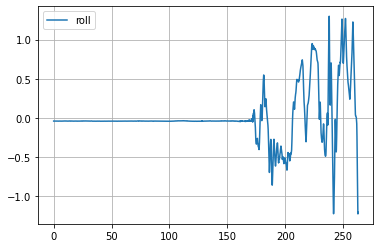

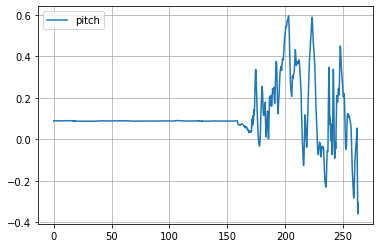

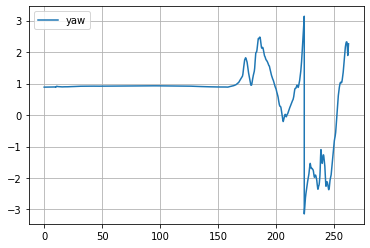

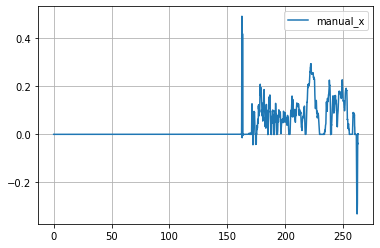

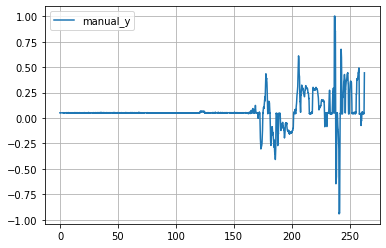

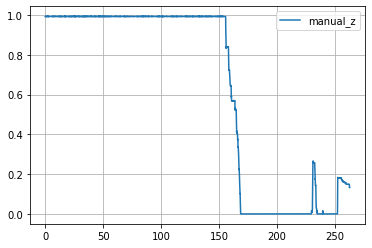

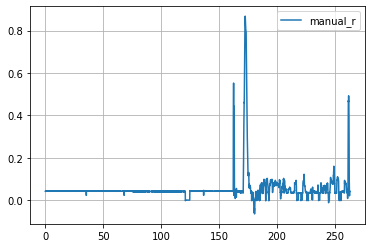

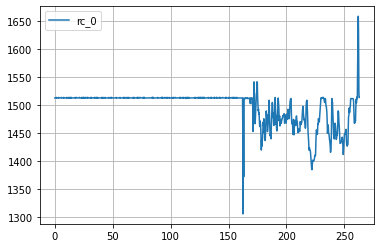

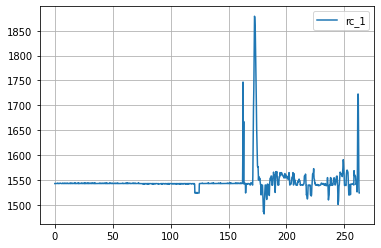

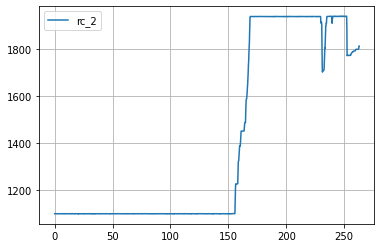

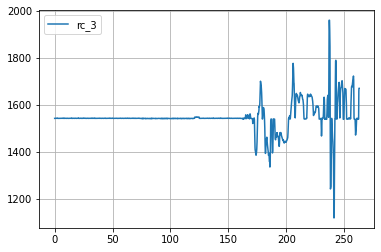

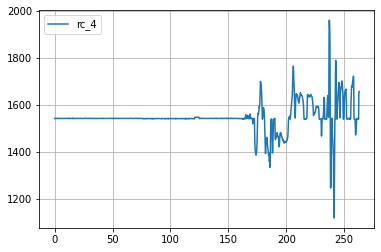

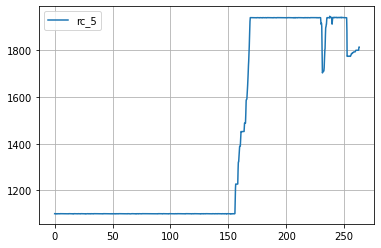

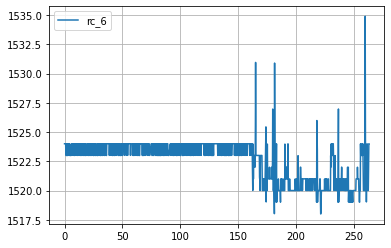

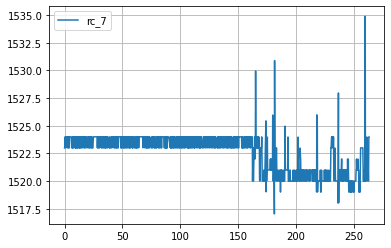

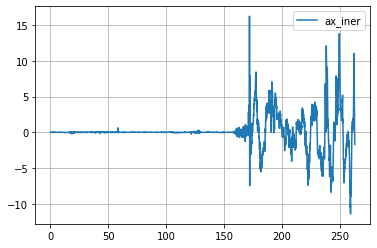

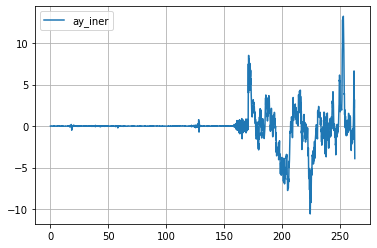

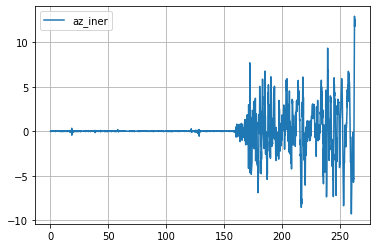

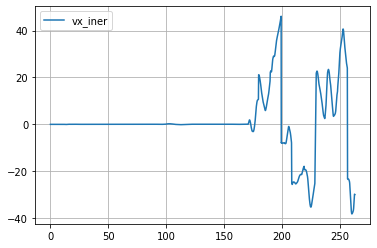

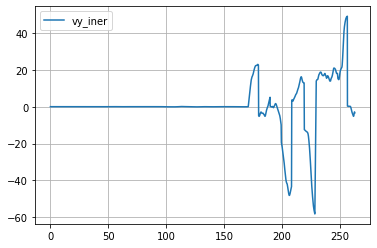

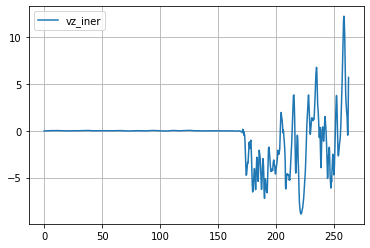

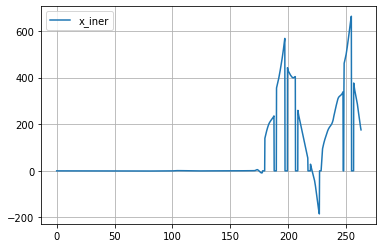

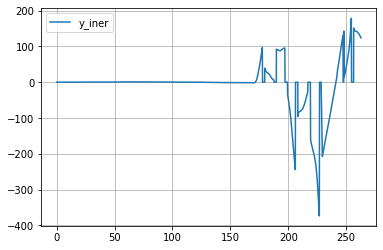

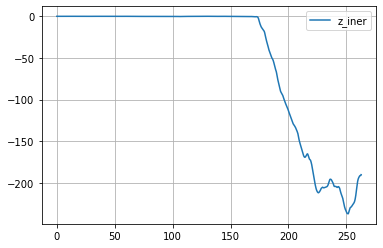

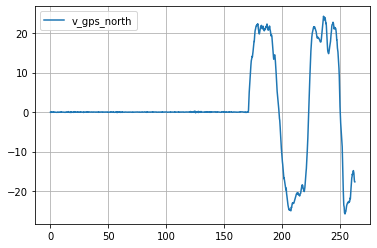

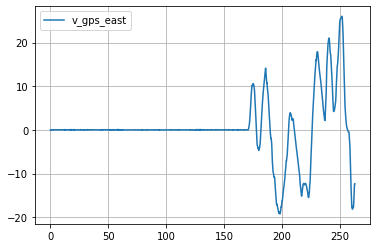

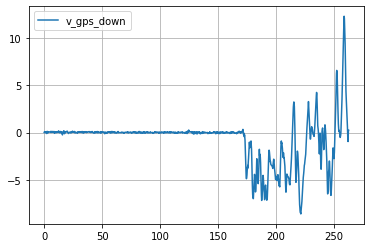

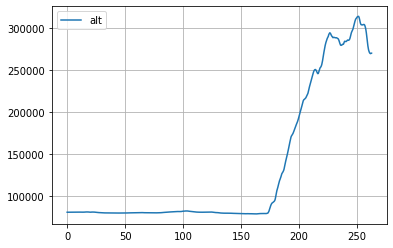

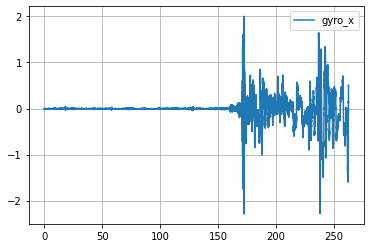

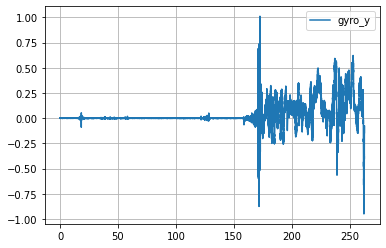

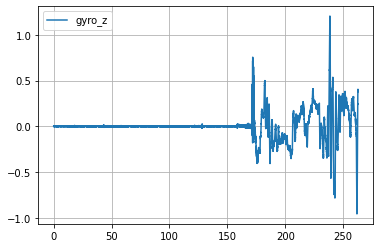

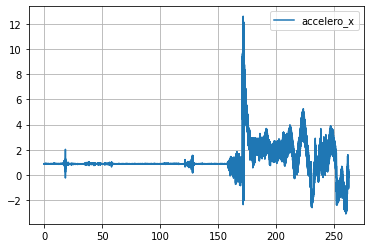

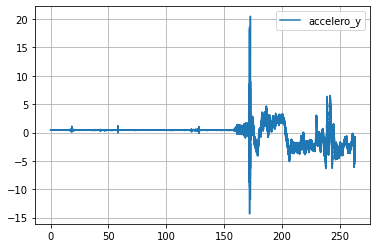

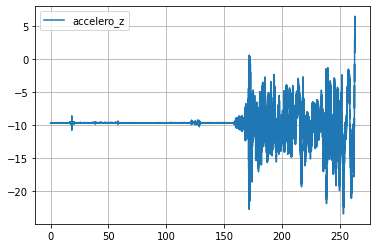

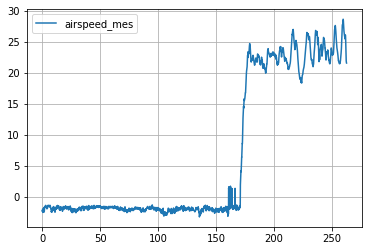

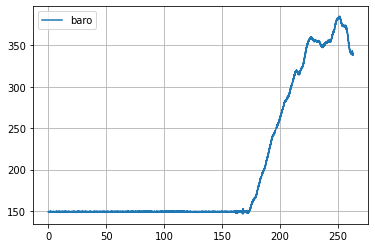

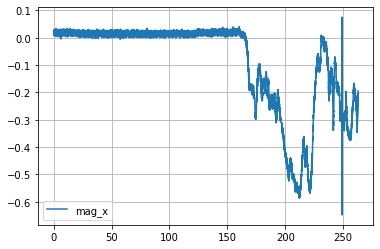

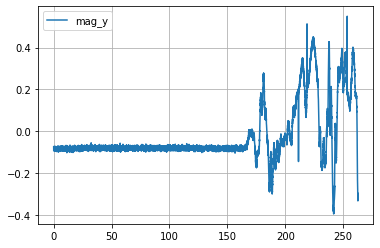

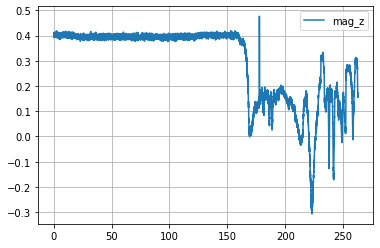

In [6]:
for k in log.DATA.keys():
    if k!='R' and k!='t' and k!="dt" and k!="init_timestamp":
        figure()
        plot(log.DATA.t,log.DATA[k],label=k)
        legend()
        grid()
    
    